In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder


#### Read CSV File

In [2]:
df = pd.read_csv('Arthritis_on_heart_attack.csv', index_col='Unnamed: 0')
df.head()

,arthritis.type,gender,bmi,diabetes,smoke,age,education,marriage,physical.activity,medical.access,blood.pressure,healthy.diet,covered.health,heart.attack
1,Non-arthritis,Male,"(25,80]",No,No,"(50,70]",School,Married,Moderate,Yes,No,Fair,No,No
2,Non-arthritis,Male,"(0,25]",No,No,"(19.9,50]",High.School,Not.married,No,Yes,No,Good,No,No
3,Non-arthritis,Male,"(25,80]",No,Yes,"(50,70]",High.School,Married,No,Yes,Yes,Good,Yes,No
4,Rheumatoid arthritis,Male,"(25,80]",Yes,No,"(50,70]",College,Married,No,Yes,Yes,Poor,Yes,No
5,Non-arthritis,Female,"(25,80]",No,No,"(19.9,50]",High.School,Married,Moderate,No,No,Fair,No,No


#### Usually the treatment group is smaller than control group

In [3]:
df['arthritis.type'].value_counts()

Non-arthritis           3544
Rheumatoid arthritis     244
Name: arthritis.type, dtype: int64

#### We have to convert categorical variables into numeric variables

In [5]:
labelencoder = LabelEncoder()
for col in df.columns:
    df[col] = labelencoder.fit_transform(df[col])

#### Check for correlation between different columns

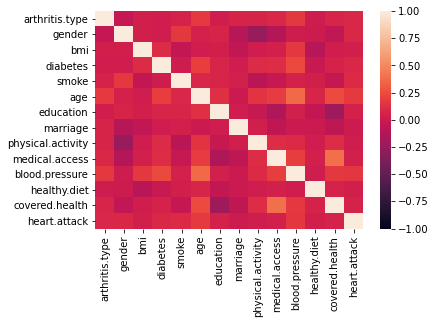

In [6]:
sns.heatmap(df.corr(), vmin=-1, vmax=1);

In [7]:
df.head()

,arthritis.type,gender,bmi,diabetes,smoke,age,education,marriage,physical.activity,medical.access,blood.pressure,healthy.diet,covered.health,heart.attack
1,0,1,1,0,0,1,2,0,1,1,0,0,0,0
2,0,1,0,0,0,0,1,1,2,1,0,1,0,0
3,0,1,1,0,1,1,1,0,2,1,1,1,1,0
4,1,1,1,1,0,1,0,0,2,1,1,2,1,0
5,0,0,1,0,0,0,1,0,1,0,0,0,0,0


#### Given all the covariates, the column arthiritis.type indicates whether the subject received is in treatment or control. We have to check whether the covariates are balanced or not.
#### To check the balance between covariates, we can look at standardized mean differences (smd), which is calculated by the difference in the means between the two groups divided by the pooled standard deviation.


In [8]:
features = df.columns.tolist()
print(features)
features.remove('arthritis.type')
features.remove('heart.attack')
agg_operations = {'arthritis.type': 'count'}
agg_operations.update({
    feature: ['mean', 'std'] for feature in features
})

agg_treatment = df.groupby('arthritis.type').agg(agg_operations)
agg_treatment.head()

['arthritis.type', 'gender', 'bmi', 'diabetes', 'smoke', 'age', 'education', 'marriage', 'physical.activity', 'medical.access', 'blood.pressure', 'healthy.diet', 'covered.health', 'heart.attack']


arthritis.type    gender                 bmi            \
                        count      mean       std      mean       std   
arthritis.type                                                          
0                        3544  0.516648  0.499793  0.685666  0.464316   
1                         244  0.438525  0.497226  0.745902  0.436248   

                diabetes               smoke                 age    ...     \
                    mean       std      mean       std      mean    ...      
arthritis.type                                                      ...      
0               0.084086  0.277556  0.437077  0.496095  0.463318    ...      
1               0.114754  0.319380  0.553279  0.498175  0.954918    ...      

               physical.activity           medical.access            \
                            mean       std           mean       std   
arthritis.type                                                        
0                       1.339447  0.811059       0.813205  0.389802   
1                       1.549180  0.715524       0.950820  0.216689   

               blood.pressure           healthy.diet           covered.health  \
                         mean       std         mean       std           mean   
arthritis.type                                                                  
0                    0.259312  0.438319     0.823363  0.504405       0.711625   
1                    0.565574  0.496700     0.844262  0.566855       0.848361   

                          
                     std  
arthritis.type            
0               0.453070  
1               0.359408  

[2 rows x 25 columns]

In [9]:
def compute_smd(agg_treatment, round_digits: int=4):
    feature_smds = []
    for feature in features:
        feature_agg_treatment = agg_treatment[feature].values
        neg_mean = feature_agg_treatment[0, 0]
        neg_std = feature_agg_treatment[0, 1]
        pos_mean = feature_agg_treatment[1, 0]
        pos_std = feature_agg_treatment[1, 1]

        smd = (pos_mean - neg_mean) / np.sqrt((pos_std ** 2 + neg_std ** 2) / 2)
        smd = round(abs(smd), round_digits)
        feature_smds.append(smd)

    return pd.DataFrame({'features': features, 'smd': feature_smds})


agg_treatment_smd = compute_smd(agg_treatment)
agg_treatment_smd

,features,smd
0,gender,0.1567
1,bmi,0.1337
2,diabetes,0.1025
3,smoke,0.2337
4,age,0.7173
5,education,0.1081
6,marriage,0.2629
7,physical.activity,0.2742
8,medical.access,0.4364
9,blood.pressure,0.6538


#### df_treatment will be the label for estimating the propensity score, and df_label will be the outcome and it has to be removed from the data frame for calculating propensity score


In [10]:
df_treatment = df['arthritis.type']
df_label = df['heart.attack']

In [11]:
df_train = df.drop(['arthritis.type', 'heart.attack'], axis=1)
print(df_train.shape)
df_train.head()

(3788, 12)


,gender,bmi,diabetes,smoke,age,education,marriage,physical.activity,medical.access,blood.pressure,healthy.diet,covered.health
1,1,1,0,0,1,2,0,1,1,0,0,0
2,1,0,0,0,0,1,1,2,1,0,1,0
3,1,1,0,1,1,1,0,2,1,1,1,1
4,1,1,1,0,1,0,0,2,1,1,2,1
5,0,1,0,0,0,1,0,1,0,0,0,0


In [12]:
df_train.describe()

,gender,bmi,diabetes,smoke,age,education,marriage,physical.activity,medical.access,blood.pressure,healthy.diet,covered.health
count,3788.000000,3788.000000,3788.000000,3788.000000,3788.000000,3788.000000,3788.000000,3788.000000,3788.000000,3788.000000,3788.000000,3788.000000
mean,0.511616,0.689546,0.086061,0.444562,0.494984,0.644403,0.398891,1.352957,0.822070,0.279039,0.824710,0.720433
std,0.499931,0.462741,0.280491,0.496983,0.689601,0.674718,0.489735,0.806806,0.382505,0.448586,0.508602,0.448846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000


#### Train the Logistic Regression model in which the model classifies the group of each patient (treatment or control) based on the impact features (covariates).
#### As the dataset is imbalanced since the control group is almost 15 times larger than the treatment group, class_weight parameter is used to weight the classes so that we have a balanced mix of each class.

In [13]:
logistic = LogisticRegression(solver='liblinear', class_weight='balanced')
logistic.fit(df_train, df_treatment)


LogisticRegression(class_weight='balanced', solver='liblinear')

In [14]:
pscore = logistic.predict_proba(df_train)[:,1]
pscore


array([0.34496714, 0.23273951, 0.70851401, ..., 0.59551345, 0.18961282,
       0.79464841])

#### Create a dataframe of Propensity Scores

In [15]:
propensity = pd.DataFrame(logistic.predict_proba(df_train)[:,1])
propensity.head()

,0
0,0.344967
1,0.232740
2,0.708514
3,0.512440
4,0.128908


#### Once the propensity score is estimated, it is better to look for the overlap before the matching process. We compare the distribution of the propensity score for the subjects in the control and treatment group.

In [16]:
pos_pscore = pscore[df_treatment == 1]
neg_pscore = pscore[df_treatment == 0]
print('treatment count:', pos_pscore.shape)
print('control count:', neg_pscore.shape)

treatment count: (244,)
control count: (3544,)


#### Visualize the propensity score distribution of both groups before matching

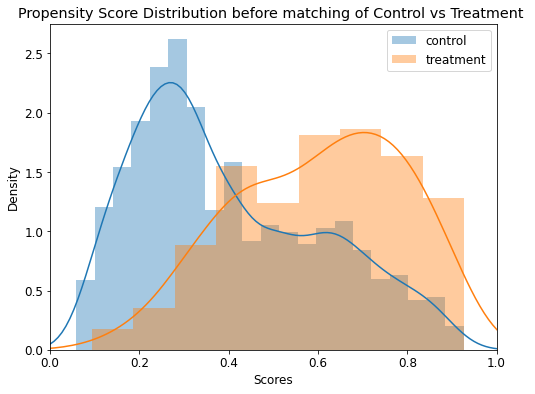

In [17]:
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(neg_pscore, label='control')
sns.distplot(pos_pscore, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution before matching of Control vs Treatment ')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.show()

#### For every record in the treatment we find its closest record in the control group by measuring the difference of their propensity scores to be smaller than a defined caliper value. 

In [18]:
def Match(groups, propensity, caliper = 0.2):
    
    # Groups divided into treatment and control
    groups = (groups == groups.unique()[1])
    N = len(groups)
    N1 = groups.sum(); N2 = N-N1
    g1 = propensity[groups == 1]
    g2 = propensity[groups == 0]
    g2 = pd.Series(g2)
    g1= pd.Series(g1)
        
    # Randomly permute the treatment group to get order for matching
    index = np.random.permutation(N1)
    matches = pd.Series(np.empty(N1))
    matches[:] = np.NAN

    for m in index:
        dist = abs(g1[m] - g2)
        if dist.min() <= caliper:
            matches[m] = dist.argmin()
            g2 = g2.drop(matches[m])
    return (matches)

In [19]:
matched_indices = Match(df_treatment,propensity[0].values)

/home/sadique/anaconda3/envs/psm/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


In [20]:
matched_indices = matched_indices.astype('int')

In [21]:
g1, g2 = propensity.values[df_treatment==1], propensity.values[df_treatment==0]

#### Checking the propensity value of the matched record from treatment and control group

In [22]:
for i, j in zip(g1,g2[matched_indices]):
    print(i,j)

[0.51243984] [0.51269503]
[0.57739651] [0.5773114]
[0.46107297] [0.46097821]
[0.85335255] [0.85335255]
[0.48009785] [0.479461]
[0.60285055] [0.60285055]
[0.44958899] [0.44958899]
[0.80370534] [0.80292691]
[0.73970662] [0.73980342]
[0.4214801] [0.4214801]
[0.70236038] [0.7022097]
[0.64422146] [0.64422146]
[0.71537839] [0.71559866]
[0.81720431] [0.81745809]
[0.75824802] [0.7581874]
[0.50229377] [0.50229377]
[0.59295342] [0.59250504]
[0.60294341] [0.60294341]
[0.64105562] [0.64105562]
[0.79105373] [0.79105373]
[0.78420137] [0.78416484]
[0.36407522] [0.36421824]
[0.76516279] [0.76578368]
[0.61696803] [0.61696803]
[0.68505329] [0.68505329]
[0.39922497] [0.39922497]
[0.51449794] [0.51449794]
[0.58453891] [0.58516074]
[0.77622419] [0.77622419]
[0.61299862] [0.61299862]
[0.80759098] [0.80759098]
[0.61696803] [0.61696803]
[0.7002116] [0.70033254]
[0.52976054] [0.52930785]
[0.79350188] [0.79350188]
[0.4206275] [0.42062364]
[0.59573902] [0.59580145]
[0.55930595] [0.55990571]
[0.22277034] [0.22277

#### Visualize the propensity score distribution of both groups after matching

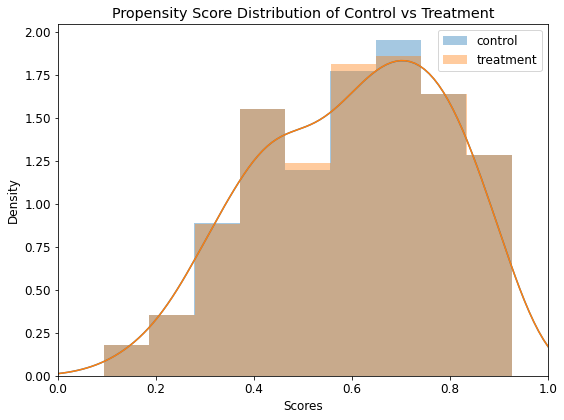

In [23]:
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(g2[matched_indices], label='control')
sns.distplot(g1, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

#### After the matching procedure, it's important to check whether the matched dataset are indeed different in terms of the covariates that we used to balance the control and treatment groups.

In [24]:
df_train['arthritis.type'] = df_treatment
df_train['heart.attack'] = df_label
df_pos = df_train[df_treatment == 1]
df_neg = df_train[df_treatment == 0].iloc[matched_indices]




In [25]:
df_matched = pd.concat([df_pos, df_neg], axis=0)
df_matched.head()

,gender,bmi,diabetes,smoke,age,education,marriage,physical.activity,medical.access,blood.pressure,healthy.diet,covered.health,arthritis.type,heart.attack
4,1,1,1,0,1,0,0,2,1,1,2,1,1,0
42,0,0,0,0,1,0,0,1,1,1,1,1,1,0
49,1,0,0,1,1,2,0,2,1,0,1,1,1,0
57,0,1,0,1,1,1,1,2,1,1,0,1,1,0
78,1,1,1,0,1,1,0,0,1,1,0,1,1,0


#### Verify that the covariates are now fairly balanced using standardized mean difference.

In [26]:
table_one_matched = df_matched.groupby('arthritis.type').agg(agg_operations)
table_one_smd_matched = compute_smd(table_one_matched)
table_one_smd_matched

,features,smd
0,gender,0.0165
1,bmi,0.1581
2,diabetes,0.0253
3,smoke,0.0412
4,age,0.0232
5,education,0.0907
6,marriage,0.0573
7,physical.activity,0.0465
8,medical.access,0.0193
9,blood.pressure,0.0000


Text(0, 0.5, 'frequency')

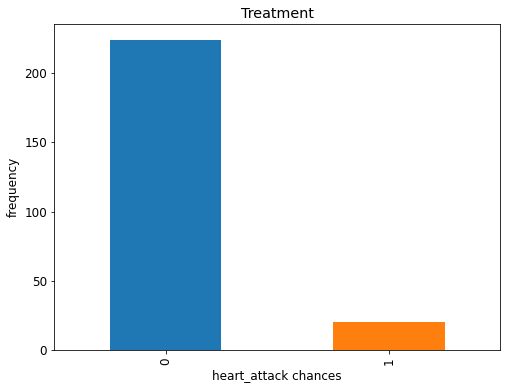

In [27]:
df_label_treat = df_matched['heart.attack'][df_treatment == 1]
df_label_treat.value_counts().plot(kind='bar', 
                                     title='Treatment')
plt.xlabel('heart_attack chances')
plt.ylabel('frequency')


Text(0, 0.5, 'frequency')

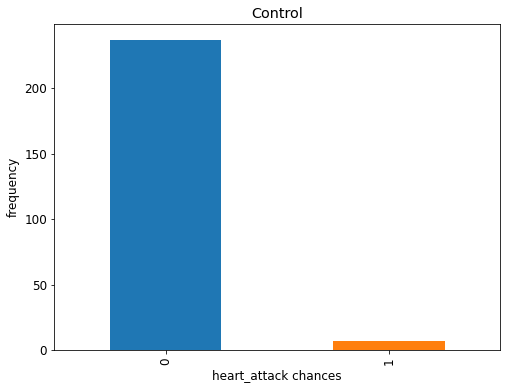

In [28]:
df_label_control= df_matched['heart.attack'][df_treatment == 0]
df_label_control.value_counts().plot(kind='bar', 
                                     title='Control')
plt.xlabel('heart_attack chances')
plt.ylabel('frequency')

#### In the problem, the following hypothesis was assumed:
#### $H_0$ - Rheumatoid arthritis patients are not prone to heart attack
#### $H_a$ - Rheumatoid arthritis patients are prone to heart attack
####  Using a paired t-test,  the p-value was found to be < 0.05, therefore, the null hypothesis can be rejected and alternative hypothesis can be accepted.
#### From this analysis, it is found that patients with Rheumatoid Arthritis (RA) are more likely to get a heart-attack.

In [29]:
stats.ttest_rel(df_pos['heart.attack'].values, df_neg['heart.attack'].values)

Ttest_relResult(statistic=2.7468017913271012, pvalue=0.006468502729863671)

### References:
#### 1.  [pymatch] https://github.com/benmiroglio/pymatch
#### 2. [Cousera] https://www.coursera.org/learn/crash-course-in-causality
#### 3. https://github.com/ethen8181/machine-learning